<h1 "text-align":"center" > Trading with MACD and RSI - Yfinance & Python </h1>
<a href = "https://medium.com/analytics-vidhya/momentum-trading-with-macd-and-rsi-yfinance-python-e5203d2e1a8a"> Thank you for the Guide </a>

In [1]:
# Importing neccessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
#Selecting the Ticker to evaluate for the program
ticker = 'TSLA'
#Last 3 years closing prices starting from Jan 2, 2018.
now = dt.datetime.now()
startyear = 2018
startmonth = 1
startday = 2
start = dt.datetime(startyear, startmonth, startday)

df = pdr.get_data_yahoo(ticker, start, now)

df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-20,751.989990,730.450012,740.349976,742.500000,29621400.0,742.500000
2022-07-21,819.799988,764.599976,765.320007,815.119995,47344100.0,815.119995
2022-07-22,842.359985,812.140015,828.659973,816.729980,34421200.0,816.729980
2022-07-25,822.440002,802.200012,816.650024,805.299988,21357800.0,805.299988
2022-07-26,801.929993,768.789978,799.539978,776.580017,22149000.0,776.580017


In [3]:
## RSI - When the RSI surpasses the horizontal 30 reference level, it's a bullish sign and when it slides below the horizontal 70 reference level, it's a bearish sign.

## 14_Day RSI

df['Up Move'] = np.nan #adding column
df['Down Move'] = np.nan #adding column
df['Average Up'] = np.nan #adding column
df['Average Down'] = np.nan #adding column

# Relative Strength
df['RS'] = np.nan #adding column
# Relative Strength Index
df['RSI'] = np.nan #adding column

## Calculate Up Move & Down Move

for x in range (1,len(df)):
    df['Up Move'][x] = 0 #sets column 'Up Move' = 0
    df['Down Move'][x] = 0 #sets column 'Down Move' = 0
    
# Compares one closing price to the previous one and calaculates move based on if it moved up or down
    if df['Adj Close'][x] > df['Adj Close'][x-1]:
        df['Up Move'] = df['Adj Close'][x] - df['Adj Close'][x-1]
        
    if df['Adj Close'][x] < df['Adj Close'][x-1]:
        df['Down Move'][x] = abs(df['Adj Close'][x] - df['Adj Close'][x-1])
        
## Calculate initial Average Up & Down, RS and RSI

df['Average Up'][14] = df['Up Move'][1:15].mean()
df['Average Down'][14] = df['Down Move'][1:15].mean()
df['RS'][14] = df['Average Up'][14] / df['Average Down'][14]
df['RSI'][14] = 100 - (100/ (1+df['RS'][14]))

## Calculate rest of Average Up, Average Down, RS, RSI

for x in range (15, len(df)):
    df['Average Up'][x] = (df['Average Up'][x-1]*13+df['Up Move'][x])/14
    df['Average Down'][x] = (df['Average Down'][x-1]*13+df['Down Move'][x])/14
    df['RS'][x] = df['Average Up'][x]/ df['Average Down'][x]
    df['RSI'][x] = 100 - (100/ (1+df['RS'][x]))

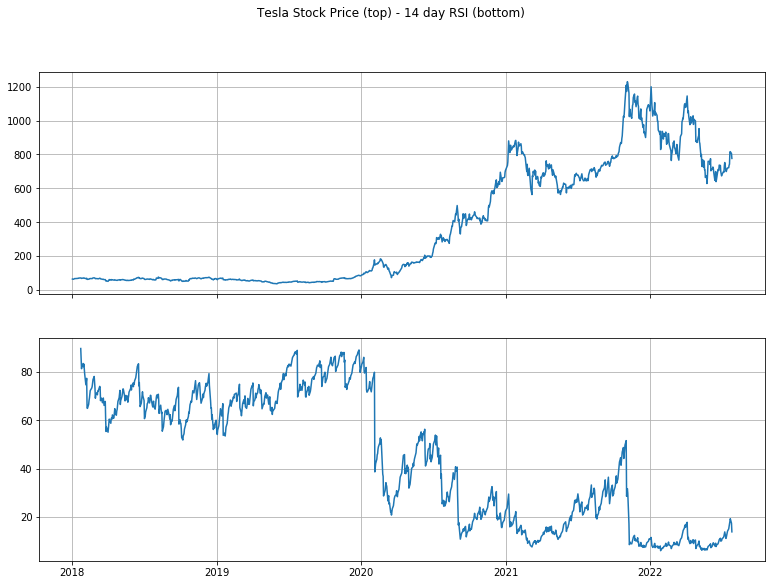

In [4]:
# Plot the RSI and 'Close Prices':
## Chart the stock price and RSI

plt.style.use('_classic_test_patch')

fig, axs = plt.subplots(2, sharex=True, figsize=(13,9))
fig.suptitle('Tesla Stock Price (top) - 14 day RSI (bottom)')

axs[0].plot(df['Adj Close'])
axs[1].plot(df['RSI'])
axs[0].grid()
axs[1].grid()

In [5]:
## Calculate the buy & sell signals
## Initialize the columns that we need

df['Long Tomorrow'] = np.nan
df['Buy Signal'] = np.nan
df['Sell Signal'] = np.nan
df['Buy RSI'] = np.nan
df['Sell RSI'] = np.nan
df['Strategy'] = np.nan

## Calculate the buy & sell signals

for x in range(15, len(df)):
    # Calculate "Long Tomorrow" column
    if ((df['RSI'][x] <= 40) & (df['RSI'][x-1]>40) ):
        df['Long Tomorrow'][x] = True
    elif ((df['Long Tomorrow'][x-1] == True) & (df['RSI'][x] <= 70)):
        df['Long Tomorrow'][x] = True
    else:
        df['Long Tomorrow'][x] = False 
    # Calculate "Buy Signal" column
    if ((df['Long Tomorrow'][x] == True) & (df['Long Tomorrow'][x-1] == False)):
        df['Buy Signal'][x] = df['Adj Close'][x]
        df['Buy RSI'][x] = df['RSI'][x]  
    # Calculate "Sell Signal" column
    if ((df['Long Tomorrow'][x] == False) & (df['Long Tomorrow'][x-1] == True)):
        df['Sell Signal'][x] = df['Adj Close'][x]
        df['Sell RSI'][x] = df['RSI'][x]

## Calculate strategy performance
df['Strategy'][15] = df['Adj Close'][15]

for x in range (16, len(df)):
        if df['Long Tomorrow'][x-1] == True:
            df['Strategy'][x] = df['Strategy'][x-1]* (df['Adj Close'][x] / df['Adj Close'][x-1])
        else:
            df['Strategy'][x] = df['Strategy'][x-1]

ValueError: 

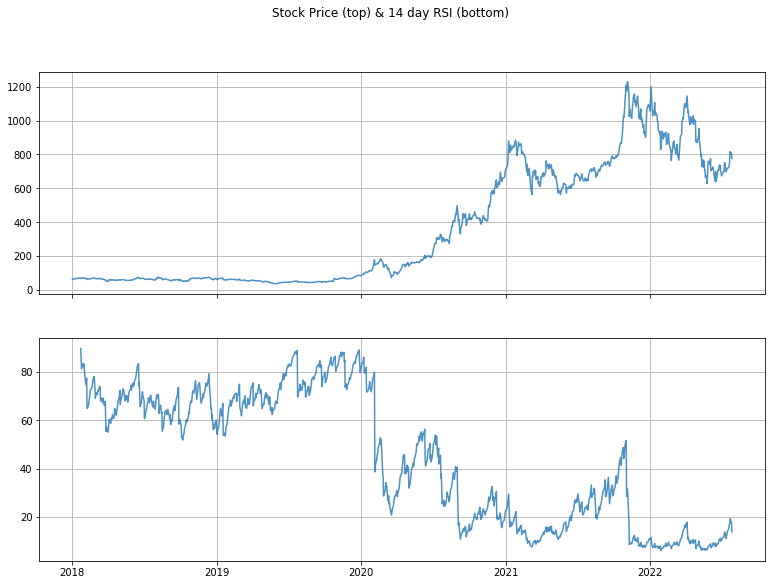

In [6]:
## Chart the buy/sell signals:
plt.style.use('_classic_test_patch')
fig, axs = plt.subplots(2, sharex=True, figsize=(13,9))
fig.suptitle('Stock Price (top) & 14 day RSI (bottom)')
## Chart the stock close price & buy/sell signals:
axs[0].scatter(df.index, df['Buy Signal'],  color = 'green',  marker = '^', alpha = 1)
axs[0].scatter(df.index, df['Sell Signal'],  color = 'red',  marker = 'v', alpha = 1)
axs[0].plot(df['Adj Close'], alpha = 0.8)
axs[0].grid()
## Chart RSI & buy/sell signals:
axs[1].scatter(df.index, df['Buy RSI'],  color = 'green', marker = '^', alpha = 1)
axs[1].scatter(df.index, df['Sell RSI'],  color = 'red', marker = 'v', alpha = 1)
axs[1].plot(df['RSI'], alpha = 0.8)
axs[1].grid()

In [7]:
## Calculate the MACD and Signal Line indicators
## Calculate the Short Term Exponential Moving Average
ShortEMA = df.Close.ewm(span=12, adjust=False).mean() 
## Calculate the Long Term Exponential Moving Average
LongEMA = df.Close.ewm(span=26, adjust=False).mean() 
## Calculate the Moving Average Convergence/Divergence (MACD)
MACD = ShortEMA - LongEMA
## Calcualte the signal line
signal = MACD.ewm(span=9, adjust=False).mean()

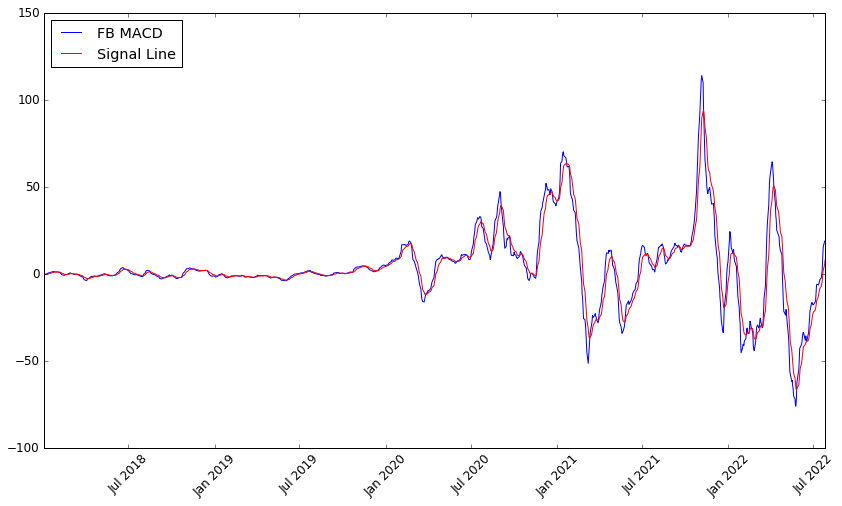

In [8]:
## Plot the Chart
plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(df.index, MACD, label='FB MACD', color = 'blue')
plt.plot(df.index, signal, label='Signal Line', color='red')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

In [9]:
## Performance statistics
## Number of trades
trade_count = df['Buy Signal'].count()
## Average Profit per/trade:
average_profit = ((df['Strategy'][-1] / df['Strategy'][15])**(1/trade_count))-1
## Number of days per/trade
total_days = df['Long Tomorrow'].count()
average_days = int(total_days / trade_count)
print('Strategy yielded ', trade_count, ' trades')
print('Average trade lasted ', average_days, ' days per trade')
print('Our average profit per trade was ', average_profit*100, '%')

C:\Users\19178\AppData\Local\Temp\ipykernel_476\1581082068.py:5: RuntimeWarning: divide by zero encountered in longlong_scalars
  average_profit = ((df['Strategy'][-1] / df['Strategy'][15])**(1/trade_count))-1
C:\Users\19178\AppData\Local\Temp\ipykernel_476\1581082068.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  average_days = int(total_days / trade_count)


ValueError: cannot convert float NaN to integer